## 1. Overview 
1. We want to evaluate a certain portfolio, and how the portfolio compares to other allocation. 
2. First we obtain a prediction of each holding's expected return by decomposing its returns to different factors (75 different factor portfolio constructed by the fama french library)
3. Using this prediction of expected return, we then compares this portfolio weighting to other traditional portfolio weights, and backtest them. 
4. Using weights and predicted expected returns, we predict the portfolio returns using the MSR weights, and compare to the posted returns by the company. 

In [39]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib 
import matplotlib.pyplot as plt 
import pandas_datareader.data as web
import seaborn as sns 

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize
import datetime 

import utils as ut
import advstatmodel as adv 
import warnings

warnings.filterwarnings('ignore')

In [ ]:
## params 

HOLDINGS = ['AVGO', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'GOOGL', 'META', 'ASML', 'ORCL', 'NVDA'] ## MODIFY ACCORDING TO THE PORTFOLIO HOLDINGS THAT YOU WANT TO ANALYSE 
START = "2018-01-01"
END = "2025-12-01"
WINDOW = 60 


In [41]:
## download ff portfolio data using web reader - else we could download the CSV 

def get_data(): 
    price = yf.download(HOLDINGS, start = START, end = END)['Close']
    returns = price.resample('M').last().pct_change().dropna() 
    returns.index = returns.index.to_period('M')

    print("--- Fetching 75 porfolios ---")
    try: 
        f1 = web.DataReader('25_Portfolios_5x5', 'famafrench', start = START, end = END)[0]
        f2 = web.DataReader('25_Portfolios_Op_Inv', 'famafrench', start = START, end = END)[0]
        f3 = web.DataReader('25_Portfolios_ME_Prior_12_2', 'famafrench', start = START, end = END)[0]
        factors = pd.concat([f1, f2, f3], axis=1) / 100.0

    except Exception as e:
        print(f"API Warning: {e}. Using Synthetic Factors.")
        factors = pd.DataFrame(np.random.normal(0, 0.03, (len(returns), 75)), index=returns.index)

    # risk free rate 
    try: 
        rf = web.DataReader("F-F_Research_Data_Factors", 'famafrench', start = START, end = END)[0]['RF'] / 100.0

    except Exception as e: 
        print(f'Warning {e}. Setting default rf')
        rf = pd.Series(0.03, index = returns.index)
        rf.index = rf.index.strftime

    # check if returns and factors have the same lenth 
    if len(returns.index) != len(factors.index): 
        print(f'Warning. Returns length: {len(returns.index)} vs Factors length: {len(factors.index)}' )

    common = returns.index.intersection(factors.index).intersection(rf.index)
    return returns.loc[common], factors.loc[common], rf.loc[common]



## 2. Machine Learning 
1. We employ LASSO and RIDGE regression to prevent overfitting. Also, since the portfolios are highly collinear, we need to use LASSO and RIDGE to "learn" the portfolio loadings. 

In [42]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
tscv = TimeSeriesSplit(n_splits=5)  # walk-forward CV to avoid leakage

def get_forecasts(returns, factors, t, window, model_type='lasso'):
    train_ret = returns.iloc[t-window:t]
    train_fac = factors.iloc[t-window:t]
    
    # Lagged Features (t-1) -> Target (t)
    X = train_fac.shift(1).dropna()
    y = train_ret.loc[X.index]
    X_curr = train_fac.iloc[[-1]]
    
    forecasts = []
    
    # DEFINE MODELS
    if model_type == 'lasso':
        # Selection: Pick specific factors
        model = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
    elif model_type == 'pcr':
        # Extraction: Reduce 75 factors to 5 latent drivers, then regress
        model = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
    elif model_type == 'ridge': 
        model = make_pipeline(StandardScaler(), RidgeCV(cv = 5))
    
    for ticker in returns.columns:
        model.fit(X, y[ticker])
        pred = model.predict(X_curr)[0]
        forecasts.append(pred)
        
    return np.array(forecasts), train_ret.cov().values


def pca_cov(factors): 
    cov = factors.cov()
    plt.figure(figsize=(16,12))
    sns.heatmap(cov, annot=True, cmap='BrBG', fmt=".2f", square=True)
    plt.title('Covariance Matrix Heatmap')
    plt.show()

# ==========================================
# 4. OPTIMIZER
# ==========================================
def optimize_weights(mu, cov):
    n = len(mu)
    if mu.max() < 0: return np.array([1/n]*n) # Defensive
    
    def neg_sharpe(w):
        r = w @ mu
        v = np.sqrt(w.T @ cov @ w)
        return -(r / v) if v > 0 else 0
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    res = minimize(neg_sharpe, [1/n]*n, bounds=bounds, constraints=cons)
    return res.x

In [46]:
COMPANY_WEIGHTS_PCT = {
    "AVGO": 9.99,  # Broadcom
    "NVDA": 9.10,  # Nvidia
    "MSFT": 8.17,  # Microsoft
    "AAPL": 4.61,  # Apple
    "TSM": 4.19,   # Taiwan Semi
    "AMZN": 3.01,  # Amazon
    "GOOGL": 2.52, # Alphabet (if your download uses GOOG not GOOGL, map below)
    "META": 2.45,  # Meta
    "ASML": 2.43,  # ASML
    "ORCL": 1.94,  # Oracle
}
# Note: these top holdings sum to 48.41% of the fund.
# We DO NOT know the remaining 51.59% from the factsheet snapshot,
# so we treat this as a "Top Holdings Proxy" and renormalize within available tickers.


# -----------------------------
# 2) Analytics
# -----------------------------
def portfolio_analytics(rets: pd.Series,
                        rf: pd.Series | float | None = None,
                        benchmark: pd.Series | None = None,
                        weights: pd.DataFrame | None = None,
                        periods_per_year: int = 12,
                        name: str = "Strategy") -> pd.Series:
    r = rets.dropna().astype(float)
    if r.empty:
        raise ValueError(f"{name}: empty return series")

    # risk-free per period
    if rf is None:
        rf_s = pd.Series(0.0, index=r.index)
    elif isinstance(rf, (int, float)):
        rf_s = pd.Series(float(rf), index=r.index)
    else:
        rf_s = rf.reindex(r.index).fillna(0.0).astype(float)

    ex = r - rf_s

    equity = (1 + r).cumprod()
    dd = equity / equity.cummax() - 1
    max_dd = float(dd.min())

    ann_ret = float(equity.iloc[-1] ** (periods_per_year / len(r)) - 1)
    ann_vol = float(r.std(ddof=1) * np.sqrt(periods_per_year))

    ex_std = float(ex.std(ddof=1))
    sharpe = float((ex.mean() / ex_std) * np.sqrt(periods_per_year)) if ex_std > 0 else np.nan

    downside = ex.copy()
    downside[downside > 0] = 0
    dd_std = float(downside.std(ddof=1))
    sortino = float((ex.mean() / dd_std) * np.sqrt(periods_per_year)) if dd_std > 0 else np.nan

    calmar = float(ann_ret / abs(max_dd)) if max_dd < 0 else np.nan
    hit = float((r > 0).mean())

    avg_turnover = np.nan
    if weights is not None:
        w = weights.reindex(r.index).dropna(how="all")
        if len(w) >= 2:
            avg_turnover = float(w.diff().abs().sum(axis=1).mean())

    # benchmark-relative
    alpha = beta = te = ir = corr = np.nan
    if benchmark is not None:
        b = benchmark.reindex(r.index).dropna().astype(float)
        common = r.index.intersection(b.index)
        if len(common) >= 12:
            rr = r.loc[common]
            bb = b.loc[common]
            active = rr - bb
            te = float(active.std(ddof=1) * np.sqrt(periods_per_year))
            a_std = float(active.std(ddof=1))
            ir = float((active.mean() / a_std) * np.sqrt(periods_per_year)) if a_std > 0 else np.nan
            varb = float(np.var(bb.values, ddof=1))
            cov = float(np.cov(rr.values, bb.values, ddof=1)[0, 1])
            beta = cov / varb if varb > 0 else np.nan
            alpha = float((rr.mean() - beta * bb.mean()) * periods_per_year) if np.isfinite(beta) else np.nan
            corr = float(rr.corr(bb))

    return pd.Series({
        "Periods": len(r),
        "CAGR": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe(excess)": sharpe,
        "Sortino(excess)": sortino,
        "MaxDD": max_dd,
        "Calmar": calmar,
        "HitRate": hit,
        "AvgTurnover": avg_turnover,
        "Alpha_vs_Bmk(ann)": alpha,
        "Beta_vs_Bmk": beta,
        "TE(ann)": te,
        "InfoRatio": ir,
        "Corr_vs_Bmk": corr,
    }, name=name)


def make_equity_curve(ret: pd.Series, start_value: float = 100.0) -> pd.Series:
    ret = ret.dropna().astype(float)
    eq = start_value * (1 + ret).cumprod()
    return eq


def main():
    # Ensure NVDA is included if you're using the factsheet weights
    global HOLDINGS
    if "NVDA" not in HOLDINGS:
        HOLDINGS = HOLDINGS + ["NVDA"]

    returns, factors, rf = get_data()
    dates = returns.index

    # Map alternative tickers if needed (safety)
    # If your data uses GOOG instead of GOOGL, shift weight to GOOG if present.
    weights_pct = COMPANY_WEIGHTS_PCT.copy()
    if "GOOGL" not in returns.columns and "GOOG" in returns.columns:
        weights_pct["GOOG"] = weights_pct.pop("GOOGL")

    # Build the company proxy weights only for available tickers, then renormalize
    w_company = pd.Series(weights_pct).reindex(returns.columns).fillna(0.0)
    if w_company.sum() <= 0:
        raise ValueError("Company weights do not overlap with your HOLDINGS columns.")
    w_company = w_company / w_company.sum()  # renormalize within known top holdings

    # Equal-weight proxy (your existing "Fund Proxy")
    w_equal = pd.Series(1.0, index=returns.columns)
    w_equal = w_equal / w_equal.sum()

    # Lists for returns + weights
    ret_fund_list, ret_company_list = [], []
    ret_lasso_list, ret_pcr_list, ret_ridge_list = [], [], []

    w_fund_list, w_company_list = [], []
    w_lasso_list, w_pcr_list, w_ridge_list = [], [], []

    print("\n--- Running Audit (monthly walk-forward) ---")

    for t in range(WINDOW, len(dates)):
        # Realized returns this month (t)
        r_t = returns.iloc[t].values

        # 1) Fund proxy: equal-weight every month
        ret_fund = float(np.dot(w_equal.values, r_t))
        ret_fund_list.append(ret_fund)
        w_fund_list.append(w_equal.values)

        # 2) Company proxy: static top-holdings weights (renormalized)
        ret_company = float(np.dot(w_company.values, r_t))
        ret_company_list.append(ret_company)
        w_company_list.append(w_company.values)

        # 3) Lasso -> MSR weights -> realized return
        mu_l, cov_l = get_forecasts(returns, factors, t, WINDOW, 'lasso')
        w_l = optimize_weights(mu_l, cov_l)
        ret_l = float(np.dot(w_l, r_t))
        ret_lasso_list.append(ret_l)
        w_lasso_list.append(w_l)

        # 4) PCR -> MSR
        mu_p, cov_p = get_forecasts(returns, factors, t, WINDOW, 'pcr')
        w_p = optimize_weights(mu_p, cov_p)
        ret_p = float(np.dot(w_p, r_t))
        ret_pcr_list.append(ret_p)
        w_pcr_list.append(w_p)

        # 5) Ridge -> MSR
        mu_r, cov_r = get_forecasts(returns, factors, t, WINDOW, 'ridge')
        w_r = optimize_weights(mu_r, cov_r)
        ret_r = float(np.dot(w_r, r_t))
        ret_ridge_list.append(ret_r)
        w_ridge_list.append(w_r)

        if t % 12 == 0:
            print(f"{dates[t]} | FundEq: {1+ret_fund: .3f} | CoTop: {1+ret_company: .3f} | Lasso: {1+ret_l: .3f} | PCR: {1+ret_p: .3f} | Ridge: {1+ret_r: .3f}")

    # Build return DataFrame (these are the actual strategy return series)
    idx = dates[WINDOW:]
    ret_df = pd.DataFrame({
        "Fund Proxy (EqualW)": ret_fund_list,
        "Company TopHold (Static)": ret_company_list,
        "Lasso->MSR": ret_lasso_list,
        "PCR->MSR": ret_pcr_list,
        "Ridge->MSR": ret_ridge_list,
    }, index=idx)

    # Build weight DataFrames (for turnover)
    cols = list(returns.columns)
    w_fund_df = pd.DataFrame(w_fund_list, index=idx, columns=cols)
    w_company_df = pd.DataFrame(w_company_list, index=idx, columns=cols)
    w_lasso_df = pd.DataFrame(w_lasso_list, index=idx, columns=cols)
    w_pcr_df = pd.DataFrame(w_pcr_list, index=idx, columns=cols)
    w_ridge_df = pd.DataFrame(w_ridge_list, index=idx, columns=cols)

    weights_map = {
        "Fund Proxy (EqualW)": w_fund_df,
        "Company TopHold (Static)": w_company_df,
        "Lasso->MSR": w_lasso_df,
        "PCR->MSR": w_pcr_df,
        "Ridge->MSR": w_ridge_df,
    }

    # Equity curves
    equity_df = ret_df.apply(lambda s: make_equity_curve(s, start_value=100.0))

    # Analytics table (benchmark vs Fund Proxy by default)
    bench = ret_df["Fund Proxy (EqualW)"]
    rf_aligned = rf.reindex(ret_df.index).fillna(0.0) if isinstance(rf, pd.Series) else rf

    stats = []
    for col in ret_df.columns:
        stats.append(
            portfolio_analytics(
                ret_df[col],
                rf=rf_aligned,
                benchmark=bench,
                weights=weights_map[col],
                name=col
            )
        )
    stats_df = pd.concat(stats, axis=1)

    print("\n--- FINAL EQUITY (start=100) ---")
    print(equity_df.iloc[-1])

    print("\n--- PORTFOLIO ANALYTICS (monthly) ---")
    display(stats_df)

    equity_df.plot(title="Equity Curves (start=100)", figsize=(10, 6), grid=True)
    plt.show()

    return ret_df, equity_df, stats_df, weights_map


[*********************100%***********************]  10 of 10 completed


--- Fetching 75 porfolios ---
API Warning: Unable to read URL: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_Op_Inv_CSV.zip
Response Text:
b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1"/>\r\n<title>404 - File or directory not found.</title>\r\n<style type="text/css">\r\n<!--\r\nbody{margin:0;font-size:.7em;font-family:Verdana, Arial, Helvetica, sans-serif;background:#EEEEEE;}\r\nfieldset{padding:0 15px 10px 15px;} \r\nh1{font-size:2.4em;margin:0;color:#FFF;}\r\nh2{font-size:1.7em;margin:0;color:#CC0000;} \r\nh3{font-size:1.2em;margin:10px 0 0 0;color:#000000;} \r\n#header{width:96%;margin:0 0 0 0;padding:6px 2% 6px 2%;font-family:"trebuchet MS", Verdana, sans-serif;color:#FFF;\r\nbackground-color:#555555;}\r\n#content{margin:0 0 0 2%;position:relative;}\r\n.content-

,Fund Proxy (EqualW),Company TopHold (Static),Lasso->MSR,PCR->MSR,Ridge->MSR
Periods,34.000000,34.000000,34.000000,34.000000,34.000000
CAGR,0.546511,0.656479,0.746643,0.690295,0.886118
AnnVol,0.222358,0.240729,0.381226,0.269832,0.323316
Sharpe(excess),1.887409,2.055734,1.539080,1.934727,2.013358
Sortino(excess),4.720672,5.557500,4.556906,5.071178,6.348340
MaxDD,-0.157351,-0.160629,-0.260111,-0.176111,-0.160231
Calmar,3.473204,4.086935,2.870476,3.919656,5.530237
HitRate,0.764706,0.764706,0.676471,0.764706,0.735294
AvgTurnover,0.000000,0.000000,1.522433,1.295778,1.522477
Alpha_vs_Bmk(ann),0.000000,0.046092,0.042869,0.063559,0.104491


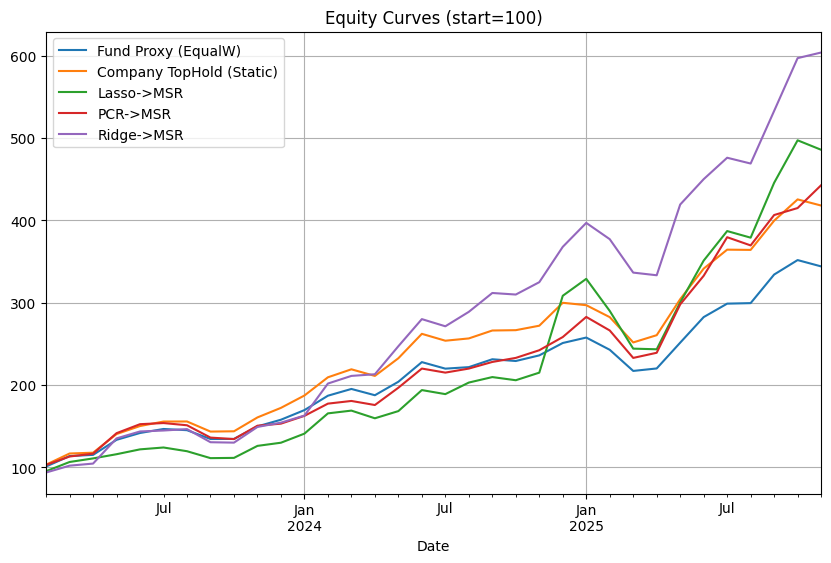

,Fund Proxy (EqualW),Company TopHold (Static),Lasso->MSR,PCR->MSR,Ridge->MSR
Date,,,,,
2025-07,0.057855,0.067500,0.102294,0.140849,0.057855
2025-08,0.002106,-0.000817,-0.020746,-0.026256,-0.014814
2025-09,0.115894,0.097430,0.175829,0.099885,0.136231
2025-10,0.052617,0.064708,0.115858,0.020863,0.120396
2025-11,-0.021834,-0.017486,-0.023130,0.066726,0.011388


In [48]:

ret_df, equity_df, stats_df, weights_map = main()

display(ret_df.tail())